<a id='home'></a>

# Modelo de crédito para pessoa física

## Conteúdo

- [Análise exploratória dos dados](#explora)
- [Pré-processamento, limpeza, e remoção de dados](#dataprep)
- [Modelos de classificação](#modelo)
  - [Bernoulli naive bayes](#texto)
  - [Gaussian naive bayes](#numer)
  - [Árvore de decisão](#categ)
  - [Stacking de modelos](#stack)
- [Avaliação da solução](#avalia)
- [Importância das variáveis](#importance)

<a id='explora'></a>

## Análise exploratória dos dados

[topo](#home)

In [1]:
import sys

sys.path.append('../python')

In [2]:
%matplotlib inline

from myutils import amostragem, dataprep
from myplots import plot_roc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
dataset = pd.read_csv('../dados/dataset.csv') \
    .drop_duplicates()

dataset.head(3)

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,NaN,10000.0,NaN,NaN,NaN,NaN,0,...,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.0,23936.0,Muriaé,MG,NaN,1.0,0,...,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.0,2600.0,18000.0,5000.0,Araxá,MG,10000.0,0.0,0,...,0.0,1.0,0.0,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN


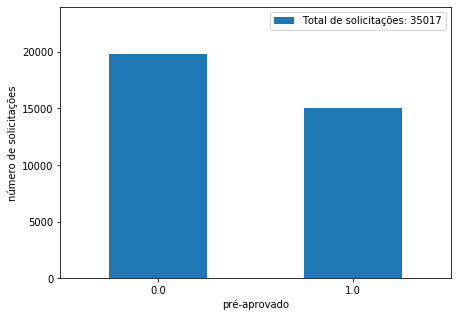

In [4]:
pre_aprovados = dataset.pre_approved.value_counts()

label = f'Total de solicitações: {dataset.shape[0]}' 

pre_aprovados.plot.bar(rot=0, figsize=(7, 5), label=label)

plt.ylabel('número de solicitações')
plt.xlabel('pré-aprovado')
plt.ylim(0, 24e3)
plt.legend();

In [5]:
print('Solicitações pré-aprovadas:', pre_aprovados[1])

Solicitações pré-aprovadas: 14998


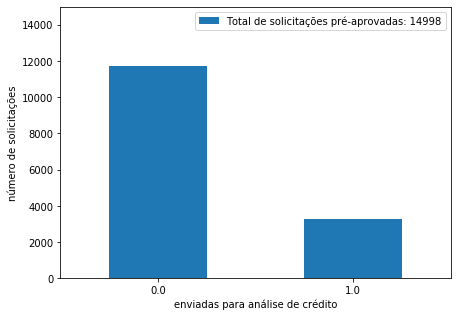

In [6]:
target = dataset[dataset.pre_approved==1.0]['sent_to_analysis'].value_counts()

label = f'Total de solicitações pré-aprovadas: {pre_aprovados[1]}' 

target.plot.bar(rot=0, figsize=(7, 5), label=label)

plt.ylabel('número de solicitações')
plt.xlabel('enviadas para análise de crédito')
plt.ylim(0, 15e3)
plt.legend();

In [7]:
print('Solicitações pré-aprovadas e enviadas para análise de crédito:', target[1])

Solicitações pré-aprovadas e enviadas para análise de crédito: 3269


<a id='dataprep'></a>

## Pré-processamento, limpeza, e remoção de dados

[topo](#home)

In [8]:
publico = dataprep(dataset)

In [9]:
""" Sumário do pré-processamento
"""

print(f'   {"coluna":>25} {"tipo":>10} {"unicos":>10} {"nulos":>10}')
      
for i, col in enumerate(publico.columns):
    col_dtype = str(publico[col].dtype)
    col_count = publico[col].nunique()
    col_nulos = publico[col].isna().sum()
    print(f'{i+1:>2} {col:>25} {col_dtype:>10} {col_count:>10} {col_nulos:>10}')

                      coluna       tipo     unicos      nulos
 1                        id      int64      13290          0
 2                       age    float64         56          0
 3            monthly_income    float64       1303          0
 4               loan_amount    float64        926          0
 5                      city     object       2098          1
 6                     state     object         27          0
 7         dishonored_checks      int64          2          0
 8             banking_debts      int64          2          0
 9          commercial_debts      int64          2          0
10                  protests      int64          2          0
11      informed_restriction      int64          3          0
12           monthly_payment    float64       2162          0
13          informed_purpose     object       8091          0
14                auto_brand     object         49          0
15                auto_model      int64       1552          0
16      

<a id='modelo'></a>

## Modelos de classificação

[topo](#home)

In [10]:
""" Amostras de treino, teste e validação
"""

target = 'sent_to_analysis'

X_train, X_teste, X_valid, y_train, y_teste, y_valid = amostragem(publico, target)

print('train:', X_train.shape)
print('teste:', X_teste.shape)
print('valid:', X_valid.shape)

train: (6645, 24)
teste: (3322, 24)
valid: (3323, 24)


<a id='zipcode'></a>

### k-nearest neighbors

[topo](#home)

In [11]:
%%time

parameters = {
    'n_neighbors': [30, 35, 40]
}

knn = GridSearchCV(
    KNeighborsClassifier(),
    parameters,
    cv=2
)

X_train_knn = X_train.zip_code.values.reshape(-1, 1)

knn.fit(X_train_knn, y_train)

CPU times: user 515 ms, sys: 3.11 ms, total: 518 ms
Wall time: 517 ms


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': [30, 35, 40]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [13]:
%%time

X_teste_knn = X_teste.zip_code.values.reshape(-1, 1)
X_valid_knn = X_valid.zip_code.values.reshape(-1, 1)

knn_score_teste = knn.predict_proba(X_teste_knn)[:, 1]
knn_score_valid = knn.predict_proba(X_valid_knn)[:, 1]

CPU times: user 31 ms, sys: 0 ns, total: 31 ms
Wall time: 30.3 ms


<a id='texto'></a>

### Bernoulli Naive bayes

[topo](#home)

In [14]:
%%time

vectorizer = CountVectorizer(
    analyzer='char_wb',
    ngram_range=(4, 4),
    binary=True,
    strip_accents='ascii'
)

bnb = Pipeline([('vec', vectorizer),
                ('bnb', BernoulliNB(binarize=None))
               ])

X_train_bnb = X_train.informed_purpose

bnb.fit(X_train_bnb, y_train)

CPU times: user 102 ms, sys: 581 µs, total: 103 ms
Wall time: 101 ms


Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='char_wb', binary=True,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(4, 4), preprocessor=None,
                                 stop_words=None, strip_accents='ascii',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('bnb',
                 BernoulliNB(alpha=1.0, binarize=None, class_prior=None,
                             fit_prior=True))],
         verbose=False)

In [15]:
%%time

X_teste_bnb = X_teste.informed_purpose
X_valid_bnb = X_valid.informed_purpose

bnb_score_teste = bnb.predict_proba(X_teste_bnb)[:, 1]
bnb_score_valid = bnb.predict_proba(X_valid_bnb)[:, 1]

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 107 ms


<a id='numer'></a>

### Gaussian naive bayes

[topo](#home)

In [16]:
%%time

gnb = Pipeline([('sca', StandardScaler()),
                ('gnb', GaussianNB())
               ])

X_train_gnb = X_train.select_dtypes(include=['float64'])

gnb.fit(X_train_gnb, y_train)

CPU times: user 9.27 ms, sys: 390 µs, total: 9.66 ms
Wall time: 8.82 ms


Pipeline(memory=None,
         steps=[('sca',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [17]:
%%time

X_teste_gnb = X_teste.select_dtypes(include=['float64'])
X_valid_gnb = X_valid.select_dtypes(include=['float64'])

gnb_score_teste = gnb.predict_proba(X_teste_gnb)[:, 1]
gnb_score_valid = gnb.predict_proba(X_valid_gnb)[:, 1]

CPU times: user 7.25 ms, sys: 3.62 ms, total: 10.9 ms
Wall time: 10.6 ms


<a id='categ'></a>

### Árvore de decisão

[topo](#home)

In [18]:
%%time

parameters = {
    'class_weight': ['balanced', None]
}

dtc = GridSearchCV(
    DecisionTreeClassifier(
        max_depth=4,
        random_state=42
    ),
    parameters,
    cv=2
)

X_train_dtc = X_train.select_dtypes(include=['int64'])

dtc.fit(X_train_dtc, y_train)

CPU times: user 51.8 ms, sys: 0 ns, total: 51.8 ms
Wall time: 51.4 ms


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
   

In [19]:
%time

X_teste_dtc = X_teste.select_dtypes(include=['int64'])
X_valid_dtc = X_valid.select_dtypes(include=['int64'])

dtc_score_teste = dtc.predict_proba(X_teste_dtc)[:, 1]
dtc_score_valid = dtc.predict_proba(X_valid_dtc)[:, 1]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


<a id='stack'></a>

### Stacking de modelos

[topo](#home)

In [20]:
X_teste_stack = np.c_[knn_score_teste, bnb_score_teste, gnb_score_teste, dtc_score_teste]
X_valid_stack = np.c_[knn_score_valid, bnb_score_valid, gnb_score_valid, dtc_score_valid]

In [21]:
%%time

clf = LogisticRegression(random_state=42, solver='lbfgs')

clf.fit(X_teste_stack, y_teste)

clf_score_valid = clf.predict_proba(X_valid_stack)[:, 1]

CPU times: user 49.4 ms, sys: 37.6 ms, total: 87 ms
Wall time: 14.3 ms


<a id='avalia'></a>

## Avaliação da solução

[topo](#home)

In [22]:
knn_auc = roc_auc_score(y_valid, knn_score_valid)
bnb_auc = roc_auc_score(y_valid, bnb_score_valid)
gnb_auc = roc_auc_score(y_valid, gnb_score_valid)
dtc_auc = roc_auc_score(y_valid, dtc_score_valid)
clf_auc = roc_auc_score(y_valid, clf_score_valid)

print('k-nearest neighbors:', round(knn_auc, 2))
print('Bernoulli Naive Bayes:', round(bnb_auc, 2))
print('Gaussian Naive Bayes:', round(gnb_auc, 2))
print('Decision Tree:', round(dtc_auc, 2))
print('Stacking:', round(clf_auc, 2))

k-nearest neighbors: 0.54
Bernoulli Naive Bayes: 0.64
Gaussian Naive Bayes: 0.64
Decision Tree: 0.72
Stacking: 0.76


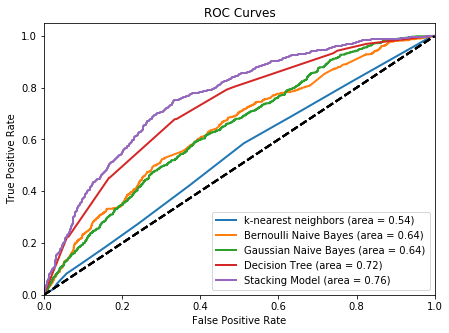

In [23]:
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)

plot_roc(y_valid, knn_score_valid, label='k-nearest neighbors', ax=ax)
plot_roc(y_valid, bnb_score_valid, label='Bernoulli Naive Bayes', ax=ax)
plot_roc(y_valid, gnb_score_valid, label='Gaussian Naive Bayes', ax=ax)
plot_roc(y_valid, dtc_score_valid, label='Decision Tree', ax=ax)
plot_roc(y_valid, clf_score_valid, label='Stacking Model', ax=ax);

<a id='importance'></a>

## Importância das variáveis

[topo](#home)

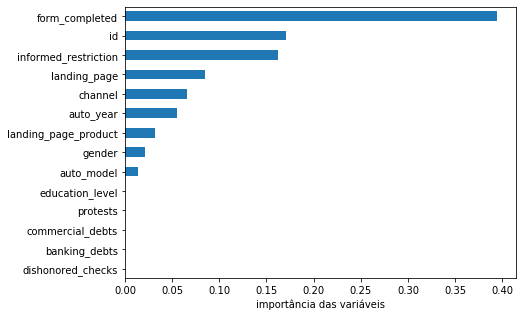

In [24]:
df = pd.DataFrame(
    data=dtc.best_estimator_.feature_importances_,
    index=X_train_dtc.columns
).sort_values(by=0)

df.plot.barh(figsize=(7, 5))

plt.xlabel('importância das variáveis')
plt.legend().remove()